In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

In [2]:
# Load the dataset
df = pd.read_csv(r'C:\Users\Admin\Downloads\Fraud.csv')

### 1. Data cleaning including missing values, outliers and multi-collinearity.

In [3]:
# Basic info about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 11 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   step            1048575 non-null  int64  
 1   type            1048575 non-null  object 
 2   amount          1048575 non-null  float64
 3   nameOrig        1048575 non-null  object 
 4   oldbalanceOrg   1048575 non-null  float64
 5   newbalanceOrig  1048575 non-null  float64
 6   nameDest        1048575 non-null  object 
 7   oldbalanceDest  1048575 non-null  float64
 8   newbalanceDest  1048575 non-null  float64
 9   isFraud         1048575 non-null  int64  
 10  isFlaggedFraud  1048575 non-null  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 88.0+ MB


In [4]:
# Check for missing values
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [5]:
# Descriptive statistics to identify outliers
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1048575.0
mean,2.696617e+01,1.586670e+05,8.740095e+05,8.938089e+05,9.781600e+05,1.114198e+06,1.089097e-03,0.0
std,1.562325e+01,2.649409e+05,2.971751e+06,3.008271e+06,2.296780e+06,2.416593e+06,3.298351e-02,0.0
min,1.000000e+00,1.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0
25%,1.500000e+01,1.214907e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0
50%,2.000000e+01,7.634333e+04,1.600200e+04,0.000000e+00,1.263772e+05,2.182604e+05,0.000000e+00,0.0
75%,3.900000e+01,2.137619e+05,1.366420e+05,1.746000e+05,9.159235e+05,1.149808e+06,0.000000e+00,0.0
max,9.500000e+01,1.000000e+07,3.890000e+07,3.890000e+07,4.210000e+07,4.220000e+07,1.000000e+00,0.0


In [6]:
# Selecting only numerical columns for the correlation matrix
numerical_df = df.select_dtypes(include=[np.number])

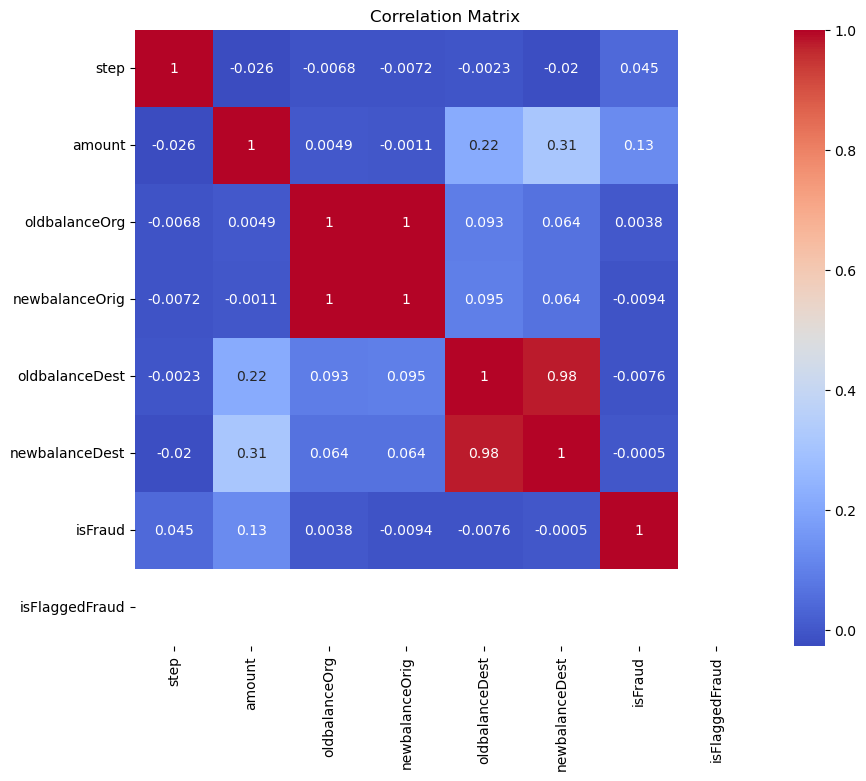

In [7]:
# Correlation matrix to check for multi-collinearity
plt.figure(figsize=(10,8))
sns.heatmap(numerical_df.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

In [8]:
# Detecting outliers using IQR for the 'amount' and balance columns
Q1 = df[['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']].quantile(0.25)
Q3 = df[['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']].quantile(0.75)
IQR = Q3 - Q1

In [9]:
# Removing rows with outliers based on 1.5 * IQR rule
df_no_outliers = df[~((df[['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']] < (Q1 - 1.5 * IQR)) | 
                              (df[['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']] > (Q3 + 1.5 * IQR))).any(axis=1)]

In [10]:
df_no_outliers.shape

(730316, 11)

In [11]:
# Encoding categorical column 'type' using one-hot encoding
df_encoded = pd.get_dummies(df_no_outliers, columns=['type'], drop_first=True)

In [12]:
# Scaling the numerical columns
scaler = StandardScaler()
numerical_columns = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']

In [13]:
df_encoded[numerical_columns] = scaler.fit_transform(df_encoded[numerical_columns])

In [14]:
df_encoded.head()

,step,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,1,-0.739668,C1231006815,1.960297,1.431815,M1979787155,-0.571758,-0.637602,0,0,False,False,True,False
1,1,-0.806480,C1666544295,-0.255611,-0.257025,M2044282225,-0.571758,-0.637602,0,0,False,False,True,False
2,1,-0.820582,C1305486145,-0.569169,-0.489352,C553264065,-0.571758,-0.637602,1,0,False,False,False,True
3,1,-0.820582,C840083671,-0.569169,-0.489352,C38997010,-0.528835,-0.637602,1,0,True,False,False,False
4,1,-0.724350,C2048537720,0.046592,-0.131168,M1230701703,-0.571758,-0.637602,0,0,False,False,True,False


### 2. Describe your fraud detection model in elaboration.

In [15]:
# Separate the target variable and features
X = df_encoded.drop(columns=['isFraud'])
y = df_encoded['isFraud']

In [16]:
# Identify non-numeric columns in the dataset
non_numeric_columns = X.select_dtypes(include=['object']).columns

In [17]:
non_numeric_columns

Index(['nameOrig', 'nameDest'], dtype='object')

In [18]:
# Dropping 'nameOrig' and 'nameDest' as they likely don't add value to the model
X = X.drop(columns=['nameOrig', 'nameDest'])

In [19]:
X.select_dtypes(include=['object']).columns

Index([], dtype='object')

In [20]:
X.dtypes

step                int64
amount            float64
oldbalanceOrg     float64
newbalanceOrig    float64
oldbalanceDest    float64
newbalanceDest    float64
isFlaggedFraud      int64
type_CASH_OUT        bool
type_DEBIT           bool
type_PAYMENT         bool
type_TRANSFER        bool
dtype: object

In [21]:
# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Logistic Regression: Great for interpreting relationships between predictors and the outcome (fraud/non-fraud)

In [22]:
# Initialize and fit the model
logreg = LogisticRegression(random_state=42)
logreg.fit(X_train, y_train)

LogisticRegression(random_state=42)

In [23]:
# Make predictions and evaluate the model
y_pred_logreg = logreg.predict(X_test)

In [24]:
print(classification_report(y_test, y_pred_logreg))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    145957
           1       0.94      0.14      0.24       107

    accuracy                           1.00    146064
   macro avg       0.97      0.57      0.62    146064
weighted avg       1.00      1.00      1.00    146064



In [25]:
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_logreg))

ROC-AUC Score: 0.5700900322774618


### 3. How did you select variables to be included in the model?

### Random Forest: Better at handling non-linear relationships and more robust for imbalanced datasets.

In [26]:
# Fit Random Forest model
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [27]:
# Get feature importance
feature_importances = pd.Series(rf.feature_importances_, index=X_train.columns)
feature_importances = feature_importances.sort_values(ascending=False)

In [28]:
feature_importances.sort_values(ascending=False)

step              0.288183
newbalanceDest    0.201640
oldbalanceOrg     0.152219
amount            0.145177
oldbalanceDest    0.126905
type_TRANSFER     0.048897
newbalanceOrig    0.022581
type_CASH_OUT     0.010641
type_PAYMENT      0.003408
type_DEBIT        0.000350
isFlaggedFraud    0.000000
dtype: float64

In [29]:
feature_importances=pd.DataFrame(feature_importances)
feature_importances.columns=['score']
feature_importances

,score
step,0.288183
newbalanceDest,0.201640
oldbalanceOrg,0.152219
amount,0.145177
oldbalanceDest,0.126905
type_TRANSFER,0.048897
newbalanceOrig,0.022581
type_CASH_OUT,0.010641
type_PAYMENT,0.003408
type_DEBIT,0.000350


In [30]:
impt_features=feature_importances.index[feature_importances.score>0.01]

In [31]:
X=df_encoded[impt_features]
X

,step,newbalanceDest,oldbalanceOrg,amount,oldbalanceDest,type_TRANSFER,newbalanceOrig,type_CASH_OUT
0,1,-0.637602,1.960297,-0.739668,-0.571758,False,1.431815,False
1,1,-0.637602,-0.255611,-0.806480,-0.571758,False,-0.257025,False
2,1,-0.637602,-0.569169,-0.820582,-0.571758,True,-0.489352,False
3,1,-0.637602,-0.569169,-0.820582,-0.528835,False,-0.489352,True
4,1,-0.637602,0.046592,-0.724350,-0.571758,False,-0.131168,False
...,...,...,...,...,...,...,...,...
1048569,95,-0.637602,-0.406466,-0.795206,-0.571758,False,-0.394636,False
1048571,95,-0.637602,0.775732,-0.739017,-0.571758,False,0.476978,False
1048572,95,-0.637602,-0.266088,-0.703642,-0.571758,False,-0.412589,False
1048573,95,-0.637602,0.776625,-0.738157,-0.571758,False,0.476466,False


In [32]:
y = df_encoded['isFraud']

In [33]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [34]:
# Train Random Forest Classifier
rf = RandomForestClassifier( random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [35]:
# Evaluate the Model
y_pred = rf.predict(X_test)

In [36]:
# Print classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    145957
           1       0.98      0.61      0.75       107

    accuracy                           1.00    146064
   macro avg       0.99      0.80      0.88    146064
weighted avg       1.00      1.00      1.00    146064



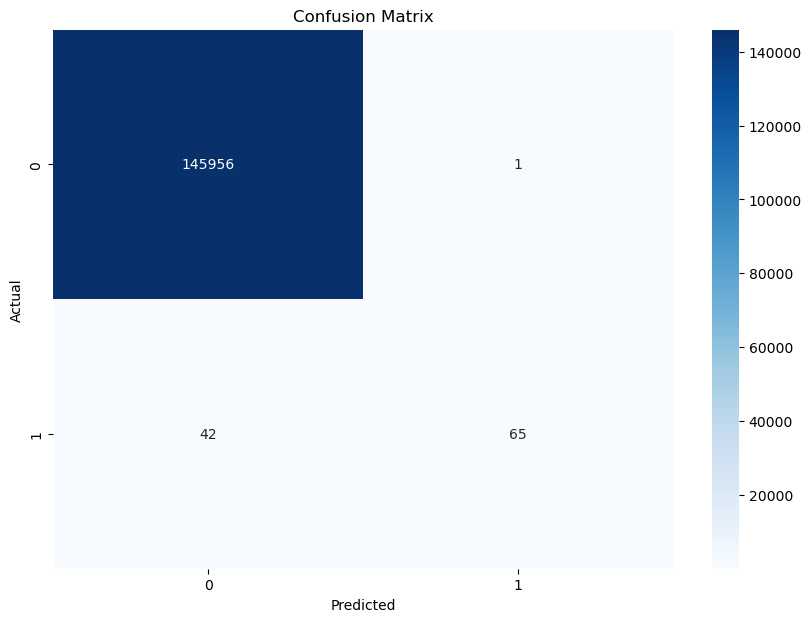

In [37]:
# Confusion matrix
confusion_mat = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

The final set of features was chosen through a combination of business intuition, correlation analysis, and feature importance derived from model 
training, ensuring that only the most relevant and non-redundant features were used in the final model.

### 4. Demonstrate the performance of the model by using best set of tools.

In [39]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm

array([[145956,      1],
       [    42,     65]], dtype=int64)

By using these evaluation tools, you can demonstrate the effectiveness of the fraud detection model across multiple dimensions. 
Here's what we can conclude based on the metrics:

Confusion Matrix: Analyze how well the model correctly and incorrectly classifies frauds.
Precision & Recall: Use these metrics to determine how well the model balances identifying frauds and minimizing false alarms.

### 5. What are the key factors that predict fraudulent customer?

In [40]:
impt_features

Index(['step', 'newbalanceDest', 'oldbalanceOrg', 'amount', 'oldbalanceDest',
       'type_TRANSFER', 'newbalanceOrig', 'type_CASH_OUT'],
      dtype='object')

The key factors that predict fraudulent transactions, based on domain knowledge and model-driven feature importance, typically include 
transaction amounts, types of transactions (e.g., CASH-OUT, TRANSFER), and sudden changes in account balances. These features make intuitive sense as
they align with common fraud behaviors seen in financial systems.

### 6. Do these factors make sense? If yes, How? If not, How not? 

The key factors—such as transaction amount, transaction type, balance changes, and flagged transactions—make sense because they are commonly linked 
to fraud patterns in real-world financial systems. Fraudsters aim to transfer or cash out large amounts quickly, making these features highly relevant 
for detecting suspicious activity. The model’s focus on these factors is thus not only statistically justified but also aligns with the business reality
of fraud prevention.

### 7. What kind of prevention should be adopted while company update its infrastructure?

To effectively prevent fraud while updating the company’s infrastructure, a multi-layered approach should be adopted. This includes implementing
real-time monitoring, multi-factor authentication, and advanced machine learning models to detect anomalies and flag suspicious transactions. 
Additionally, establishing internal security protocols, educating customers, and maintaining a dedicated fraud response team will further strengthen
fraud prevention efforts. Combining these strategies ensures a robust infrastructure capable of both preventing and responding to fraud effectively.

### 8. Assuming these actions have been implemented, how would you determine if they work?

To determine if the implemented fraud prevention measures are working, it's essential to continuously monitor KPIs such as fraud detection rates, 
false positives, and financial impact.  Tracking customer satisfaction, and regularly conducting security audits are critical steps to ensure the system
remains effective over time. Additionally, monitoring emerging fraud patterns and retraining machine learning models as needed will help ensure the 
system adapts to new threats. By combining these strategies, the company can assess and continuously improve the effectiveness of its fraud prevention 
infrastructure.